### Imports

In [1]:
import numpy as np
import re
from matplotlib import pyplot as plt
from pymongo import MongoClient
from tqdm.notebook import tqdm
from pprint import PrettyPrinter
from typing import Union, Iterable

pprint = PrettyPrinter().pprint

### Load DB

In [2]:
db = MongoClient("mongodb://localhost:27017")["cuda_snippets"]
train_db = db["train"]
validation_db = db["validation"]

Plot functions

In [3]:

def plot(data : Union[list, np.ndarray], labels : Iterable, title = "", xlab = "", ylab = "", plot_type=plt.plot):
    assert len(data) == len(labels)
    
    plt.tight_layout()
    plt.figure()
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    for label_data, label in zip(data, labels):
        plt.bar()
        plot_type(label_data, label=label)
        
    plt.legend()
    plt.show()
    
def plot_bar(x, height, labels, title = "", xlab = "", ylab = "", label_rotation=0):
    assert len(x) == len(labels) and len(height) == len(labels)
    
    plt.tight_layout()
    plt.figure()
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(rotation=label_rotation, ha='right')
    
    for label_x, label_height, label in zip(x, height, labels):
        plt.bar(label_x, label_height, label=label)
        
    plt.legend()
    plt.show()
    

Analyze compile error ratio

In [5]:
not_validated = train_db.count_documents({"validation" : {"$exists" : False}}) + \
    validation_db.count_documents({"validation" : {"$exists" : False}})
compiled_successfully = train_db.count_documents({"validation.compiled" : True}) + \
    validation_db.count_documents({"validation.compiled" : True})
compiled_failed = train_db.count_documents({"validation.compiled" : False}) + \
    validation_db.count_documents({"validation.compiled" : False})

s = sum([not_validated, compiled_successfully, compiled_failed])
ss = sum([compiled_successfully, compiled_failed])
           
print(f"not validated : {not_validated} ({not_validated/s:.2%})")
print(f"compiled      : {compiled_successfully} ({compiled_successfully/s:.2%}, {compiled_successfully/ss:.2%})")
print(f"failed        : {compiled_failed} ({compiled_failed/s:.2%}, {compiled_failed/ss:.2%})")



not validated : 0 (0.00%)
compiled      : 190005 (39.06%, 39.06%)
failed        : 296409 (60.94%, 60.94%)


Get histogram of errors (Counts only one type of error per kernel)

Count error per repository

In [4]:
from typing import Dict


def get_repos() -> dict:
    res = {
        "train" : set(),
        "validation" : set()
    }
    
    res["train"].update([doc["repo_name"] for doc in train_db.find({})])
    res["validation"].update([doc["repo_name"] for doc in validation_db.find({})])

    return res

def get_repo_errors(repo_name : str) -> Dict[str, set]:
    res = {
        "train" : [],
        "validation" : []
    }
    
    res["train"] = train_db.aggregate([
      {"$match" : {"repo_name" : repo_name, "validation.compiled" : False}},
      {"$replaceRoot" : {"newRoot" : {"$arrayElemAt" : ["$validation.iterations", -1]}}},
      {"$replaceRoot" : {"newRoot" : "$error_analyses"}}    
    ])
    
    res["validation"] = validation_db.aggregate([
      {"$match" : {"repo_name" : repo_name, "validation.compiled" : False}},
      {"$replaceRoot" : {"newRoot" : {"$arrayElemAt" : ["$validation.iterations", -1]}}},
      {"$replaceRoot" : {"newRoot" : "$error_analyses"}}    
    ])
    
    return res
    
def count_errors_in_collection(collection) -> dict:

    kernel_validation_list = []
    missing_tokens_error_counter = 0
    wrong_vals_error_counter = 0
    syntax_error_counter = 0
    missing_types_error_counter = 0
    include_error_counter = 0
    already_defined_error_counter = 0

    not_compiled_kernels = collection.find({"validation.compiled" : False})
    for kernel in tqdm(not_compiled_kernels, leave=False):
        last_error_analysis = kernel.get("validation").get("iterations")[-1].get("error_analyses")
        kernel_validation_list.append({**last_error_analysis, "id" : kernel["_id"]})
        if len(last_error_analysis.get("missing_tokens")) > 0:
            missing_tokens_error_counter += 1
        if len(last_error_analysis.get("wrong_vals")) > 0:
            wrong_vals_error_counter += 1
        if len(last_error_analysis.get("syntax_errors")) > 0:
            syntax_error_counter += 1
        if len(last_error_analysis.get("missing_types")) > 0:
            missing_types_error_counter += 1
        if len(last_error_analysis.get("include_errors")) > 0:
            include_error_counter += 1
        if len(last_error_analysis.get("already_defined_errors")) > 0:
            already_defined_error_counter += 1
            
    return {
        "kernel_validations" :  kernel_validation_list,
        "missing_tokens" : missing_tokens_error_counter,
        "wrong_vals" : wrong_vals_error_counter,
        "syntax_errors" : syntax_error_counter,
        "missing_types" : missing_types_error_counter,
        "include_errors" : include_error_counter,
        "already_defined_errors" : already_defined_error_counter
    }
    
def count_errors_in_list(error_list : list) -> dict:

    missing_tokens_error_counter = 0
    wrong_vals_error_counter = 0
    syntax_error_counter = 0
    missing_types_error_counter = 0
    include_error_counter = 0
    already_defined_error_counter = 0

    for last_error_analysis in error_list:
        if len(last_error_analysis.get("missing_tokens")) > 0:
            missing_tokens_error_counter += 1
        if len(last_error_analysis.get("wrong_vals")) > 0:
            wrong_vals_error_counter += 1
        if len(last_error_analysis.get("syntax_errors")) > 0:
            syntax_error_counter += 1
        if len(last_error_analysis.get("missing_types")) > 0:
            missing_types_error_counter += 1
        if len(last_error_analysis.get("include_errors")) > 0:
            include_error_counter += 1
        if len(last_error_analysis.get("already_defined_errors")) > 0:
            already_defined_error_counter += 1
            
    return {
        "missing_tokens" : missing_tokens_error_counter,
        "wrong_vals" : wrong_vals_error_counter,
        "syntax_errors" : syntax_error_counter,
        "missing_types" : missing_types_error_counter,
        "include_errors" : include_error_counter,
        "already_defined_errors" : already_defined_error_counter
    }    
    
def sum_dicts(*ds) -> dict:
    result = {}
    for d in ds:        
        for k, v in d.items():
            if k not in result:
                result[k] = 0
            result[k] += v
    
    return result

0it [00:00, ?it/s]

0it [00:00, ?it/s]

train. errors:
{'already_defined_errors': 2641,
 'include_errors': 0,
 'missing_tokens': 45599,
 'missing_types': 15672,
 'syntax_errors': 24613,
 'wrong_vals': 64}
val. errors:
{'already_defined_errors': 208,
 'include_errors': 0,
 'missing_tokens': 4514,
 'missing_types': 1812,
 'syntax_errors': 2209,
 'wrong_vals': 5}
total errors:
{'already_defined_errors': 2849,
 'include_errors': 0,
 'missing_tokens': 50113,
 'missing_types': 17484,
 'syntax_errors': 26822,
 'wrong_vals': 69}


<Figure size 640x480 with 0 Axes>

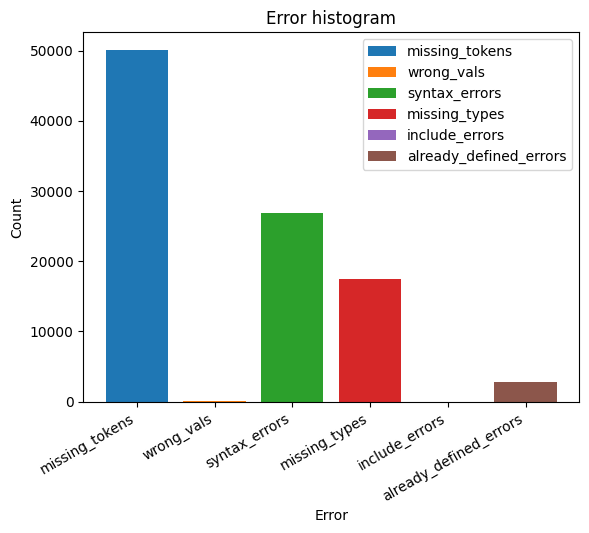

In [7]:
train_errors = count_errors_in_collection(train_db)
val_errors = count_errors_in_collection(validation_db)

kernel_validation_list = [*train_errors.get("kernel_validations"), *val_errors.get("kernel_validations")]
del train_errors["kernel_validations"]
del val_errors["kernel_validations"]

print("train. errors:")
pprint(train_errors)

print("val. errors:")
pprint(val_errors)

total_errors = sum_dicts(train_errors, val_errors)
print("total errors:")
pprint(total_errors)
plot_bar(total_errors.keys(), total_errors.values(), total_errors.keys(), "Error histogram", "Error", "Count", label_rotation=30)



Get used repositories

In [8]:
train_repo_set, validation_repo_set = get_repos().values()
total_repo_set = train_repo_set.union(validation_repo_set)

print(f"Repos in train part:      {len(train_repo_set)}")
print(f"Repos in validation part: {len(validation_repo_set)}")
print(f"Total: {len(total_repo_set)}")

Repos in train part:      6774
Repos in validation part: 2940
Total: 7028


In [9]:

train_repo_errors_dict = {}
validation_repo_errors_dict = {}
train_repo_error_count_dict = {}
validation_repo_error_count_dict = {}

pb = tqdm(total_repo_set, bar_format='{l_bar}{r_bar}{bar:-10b}')
print("Groupping errors by repo_name")
for repo_name in pb:
    pb.set_postfix_str(f"{repo_name}")
    train_errors, validation_errors = get_repo_errors(repo_name).values()
    train_repo_errors_dict[repo_name] = list(train_errors)
    validation_repo_errors_dict[repo_name] = list(validation_errors)
    train_repo_error_count_dict[repo_name] = count_errors_in_list(train_repo_errors_dict[repo_name])
    validation_repo_error_count_dict[repo_name] = count_errors_in_list(validation_repo_errors_dict[repo_name])
    
train_repo_error_count_dict = {repo_name : sum(errors.values()) for repo_name, errors in train_repo_error_count_dict.items()}
validation_repo_error_count_dict = {repo_name : sum(errors.values()) for repo_name, errors in validation_repo_error_count_dict.items()}

sort_dict_desc = lambda d: sorted(d.items(), key=lambda x : x[1], reverse=True)
show_first_n = 10

train_sorted_error_count_dict = sort_dict_desc(train_repo_error_count_dict)[:show_first_n]
validation_sorted_error_count_dict = sort_dict_desc(validation_repo_error_count_dict)[:show_first_n]

print("Train:")
for i, (val) in enumerate(train_sorted_error_count_dict, 1):
    print(f"{i}.\t{val}")

print("Validation:")
for i, (val) in enumerate(validation_sorted_error_count_dict, 1):
    print(f"{i}.\t{val}")


  0%|| 0/7028 [00:00<?, ?it/s]

Groupping errors by repo_name
Train:
1.	('cuda-samples-master', 5404)
2.	('cuda-master', 3128)
3.	('Cuda-master', 2863)
4.	('CUDA-Samples-v11.2-main', 2686)
5.	('CUDA-DDP-main', 2603)
6.	('cuda-debug-master', 2592)
7.	('CUDA-Programming-Starter-Kit-master', 2587)
8.	('CUDA_NTT_v5_8-master', 2578)
9.	('cuda_headers-master', 2566)
10.	('Programowanie-w-CUDA-na-NVIDIA-GPU-master', 2429)
Validation:
1.	('SymmThinningCUDA-master', 456)
2.	('cuda-samples-master', 449)
3.	('Programowanie-w-CUDA-na-NVIDIA-GPU-master', 380)
4.	('thrust-main', 355)
5.	('cuda-master', 306)
6.	('Cuda-master', 287)
7.	('ISPH_NVIDIA_CUDA_CONTEST-master', 265)
8.	('cuda_headers-master', 234)
9.	('thrust-cuda-11.6-annotation-master', 229)
10.	('CUDA-Programming-Starter-Kit-master', 222)


Most common missing tokens

In [10]:
def most_common_missing_tokens_in_repo(error_list : Iterable):
    missing_tokens_dict = {}
    for kernel_validation in tqdm(error_list, bar_format='{l_bar}{r_bar}{bar:-10b}'):
        missing_tokens_set = set()
        for missing_token in kernel_validation.get("missing_tokens"):
            if missing_token.get("identifier") in missing_tokens_set:
                continue
            
            missing_tokens_set.add(missing_token.get("identifier"))
            if missing_token.get("identifier") not in missing_tokens_dict:
                missing_tokens_dict[missing_token.get("identifier")] = 0
            missing_tokens_dict[missing_token.get("identifier")] += 1
    return missing_tokens_dict

train_most_faulty_repo_name = train_sorted_error_count_dict[0][0]
validation_most_faulty_repo_name = validation_sorted_error_count_dict[0][0]

show_first_n = 10

train_missing_tokens_count_dict = most_common_missing_tokens_in_repo(train_repo_errors_dict[train_most_faulty_repo_name])
print(f"Train repo: {train_most_faulty_repo_name}")
print(f"Total missing tokens = {len(train_missing_tokens_count_dict)}\nShowing first {show_first_n}:")
train_most_missed_tokens = sorted(train_missing_tokens_count_dict.items(), key=lambda x : x[1], reverse=True)[:show_first_n]
for i, (val) in enumerate(train_most_missed_tokens[:min(len(train_most_missed_tokens), show_first_n)], 1):
    print(f"{i}.\t{val}")

validation_missing_tokens_count_dict = most_common_missing_tokens_in_repo(validation_repo_errors_dict[validation_most_faulty_repo_name])
print(f"Validation repo: {validation_most_faulty_repo_name}")
print(f"Validation total missing tokens = {len(validation_missing_tokens_count_dict)}\nShowing first {show_first_n}:")
validation_most_missed_tokens = sorted(validation_missing_tokens_count_dict.items(), key=lambda x : x[1], reverse=True)
for i, (val) in enumerate(validation_most_missed_tokens[:min(len(validation_missing_tokens_count_dict), show_first_n)], 1):
    print(f"{i}.\t{val}")
    
most_missed_tokens = sum_dicts(train_missing_tokens_count_dict, validation_missing_tokens_count_dict)
most_missed_tokens_sorted = sorted(most_missed_tokens.items(), key=lambda x : x[1], reverse=True)

  0%|| 0/8775 [00:00<?, ?it/s]

Train repo: cuda-samples-master
Total missing tokens = 685
Showing first 10:
1.	('get_high_word', 202)
2.	('set_high_word', 202)
3.	('z', 201)
4.	('trim', 201)
5.	('thread_block', 198)
6.	('set_float_word', 165)
7.	('insert_words', 164)
8.	('type', 125)
9.	('composite', 124)
10.	('sync', 119)


  0%|| 0/408 [00:00<?, ?it/s]

Validation repo: SymmThinningCUDA-master
Validation total missing tokens = 84
Showing first 10:
1.	('self_t', 42)
2.	('value_type', 21)
3.	('reference', 20)
4.	('input1', 20)
5.	('UnaryOp', 19)
6.	('get_high_word', 18)
7.	('set_high_word', 18)
8.	('z', 18)
9.	('trim', 18)
10.	('input2', 18)


Show kernels with specified error

In [11]:
def find_kernels_with_missing_token(token_name, repo_name=None):
    kernels = []
    
    projection = {"$project" : {"_id" : "$_id", "last_validation" : {"$slice" : ["$validation.iterations", -1]}, "comment" : "$comment", "header" : "$header", "body" : "$body"}}
    mtch = {"$match" : {"last_validation.error_analyses.missing_tokens" : {"$elemMatch" : {"identifier" : token_name}}}}
    if repo_name is not None:
        mtch["repo_name"] = repo_name
    
    kernels.extend([*train_db.aggregate([
        projection,
        mtch
    ])])
    
    kernels.extend([*validation_db.aggregate([
        projection,
        mtch
    ])])
    
    return kernels

def kernels_in_repo(repo_name : str) -> int:
    return train_db.count_documents({"repo_name" : repo_name}) + validation_db.count_documents({"repo_name" : repo_name})


In [12]:
# Searching kernels from most faulty repo with most missed token
print(f"Total number of kernels in repo '{train_most_faulty_repo_name}': {kernels_in_repo(train_repo_errors_dict[train_most_faulty_repo_name])}")
for i, (val) in enumerate(most_missed_tokens_sorted[:min(len(most_missed_tokens_sorted), show_first_n)], 1):
    print(f"{i}.\t{val}")

print(f"Searching token : {most_missed_tokens_sorted[0][0]}")
kernels = find_kernels_with_missing_token(most_missed_tokens_sorted[0][0])
print(kernels[0].get("_id"))

Total number of kernels in repo 'cuda-samples-master': 0
1.	('get_high_word', 220)
2.	('set_high_word', 220)
3.	('z', 219)
4.	('trim', 219)
5.	('thread_block', 198)
6.	('set_float_word', 178)
7.	('insert_words', 177)
8.	('type', 126)
9.	('composite', 124)
10.	('sync', 119)
Searching token : get_high_word
642db633b043c6fb499acbd9


## Syntax error analysis

In [13]:
syntax_error_tokens = {}
wanted_kernel_ids = set()
expected_token_re = re.compile(".*expected a \"(\S+)\"")
for kernel_validation in tqdm(kernel_validation_list):
    for syntax_error_obj in kernel_validation.get("syntax_errors"):
        if res := expected_token_re.match(syntax_error_obj["line"]):
            if res[1] not in syntax_error_tokens:
                syntax_error_tokens[res[1]] = 0
            syntax_error_tokens[res[1]] += 1
            wanted_kernel_ids.add(kernel_validation.get("id"))

show_first_n = min(20, len(syntax_error_tokens))
print(f"total expected tokens = {len(syntax_error_tokens)}\nShowing first {show_first_n}:")
first_n_keys = sorted(syntax_error_tokens.items(), key=lambda x : x[1], reverse=True)[:show_first_n]
for i, (val) in enumerate(first_n_keys, 1):
    print(f"{i}.\t{val}")

  0%|          | 0/296409 [00:00<?, ?it/s]

total expected tokens = 9
Showing first 9:
1.	(';', 31598)
2.	(']', 25815)
3.	(')', 6813)
4.	('{', 3718)
5.	('>', 1918)
6.	(',', 460)
7.	(':', 162)
8.	('(', 158)
9.	('}', 102)


### Statistics

In [14]:
def count_kernels_with_less_than_n_errors(n : int) -> int:
    
    def count_db(db) -> int:
        db_count = 0
        not_compiled_kernels = db.find({"validation.compiled" : False})
        for kernel in not_compiled_kernels:
            last_error_analyses = kernel.get("validation").get("iterations")[0].get("error_analyses")
            kernel_errors_count = sum([len(errors) for errors in last_error_analyses.values()])
            if kernel_errors_count < n:
                db_count += 1
        return db_count
    
    return count_db(train_db) + count_db(validation_db)

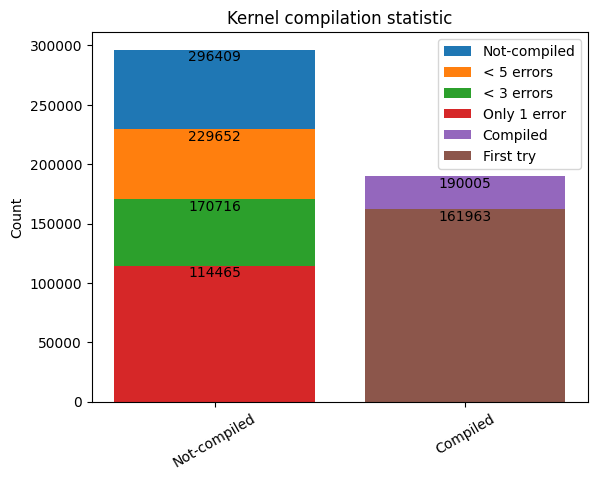

In [15]:
# Compiled statistics
total = train_db.count_documents({}) + validation_db.count_documents({})

not_compiled = train_db.count_documents({"validation.compiled" : False}) + \
    validation_db.count_documents({"validation.compiled" : False})
    
compiled = total - not_compiled

compiled_on_first_try = train_db.count_documents({"validation.compiled" : True, "validation.iterations.1" : {"$exists" : False}}) + \
    validation_db.count_documents({"validation.compiled" : True, "validation.iterations.1" : {"$exists" : False}})

less_than_2_errors = count_kernels_with_less_than_n_errors(2)
less_than_3_errors = count_kernels_with_less_than_n_errors(3)
less_than_5_errors = count_kernels_with_less_than_n_errors(5)


x = ["Not-compiled", "Compiled"]
x_axis = np.arange(len(x))
plt.ylabel("Count")
plt.title("Kernel compilation statistic")
plt.xticks(rotation=30)

rects = []

# rects.append(plt.bar(x[0], [total], label=x[0], align='center'))
rects.append(plt.bar(x[0], [not_compiled], label="Not-compiled", align='center'))
rects.append(plt.bar(x[0], [less_than_5_errors], label="< 5 errors", align='center'))
rects.append(plt.bar(x[0], [less_than_3_errors], label="< 3 errors", align='center'))
rects.append(plt.bar(x[0], [less_than_2_errors], label="Only 1 error", align='center'))
rects.append(plt.bar(x[1], [compiled], label="Compiled", align='center'))
rects.append(plt.bar(x[1], [compiled_on_first_try], label="First try", align='center'))
# rects.append(plt.bar("", [], label="", align='center')) # Room for legend

for i, rect in enumerate(rects):
    height = rect.get_children()[0].get_height() - total/40
    height_text = rect.get_children()[0].get_height()
    # if i in [1,2,3,4]:
    #     height_text -= compiled
    # if i == 1:
    #     height += total//20
    # if i == 2:
    #     height += total//10
    plt.text(rect.get_children()[0].get_x() + rect.get_children()[0].get_width() / 2.0, height, f'{height_text:.0f}', ha='center', va='bottom')

plt.legend()
plt.show()

Do error analyses for error within the file

In [16]:
def count_local_errors_in_collection(collection) -> dict:

    missing_tokens_error_counter = 0
    wrong_vals_error_counter = 0
    syntax_error_counter = 0
    missing_types_error_counter = 0
    include_error_counter = 0
    already_defined_error_counter = 0
    
    is_local_error = lambda error, filename: error.get("line").find(filename) != -1
    any_local_error = lambda errors, filename: any([is_local_error(error, filename) for error in errors])

    not_compiled_kernels = collection.find({"validation.compiled" : False})
    for kernel in tqdm(not_compiled_kernels, leave=False):
        filename = kernel.get("filename")
        last_error_analysis = kernel.get("validation").get("iterations")[-1].get("error_analyses")
        if any_local_error(last_error_analysis.get("missing_tokens"), filename):
            missing_tokens_error_counter += 1
        if any_local_error(last_error_analysis.get("wrong_vals"), filename):
            wrong_vals_error_counter += 1
        if any_local_error(last_error_analysis.get("syntax_errors"), filename):
            syntax_error_counter += 1
        if any_local_error(last_error_analysis.get("missing_types"), filename):
            missing_types_error_counter += 1
        if any_local_error(last_error_analysis.get("include_errors"), filename):
            include_error_counter += 1
        if any_local_error(last_error_analysis.get("already_defined_errors"), filename):
            already_defined_error_counter += 1
            
    return {
        "missing_tokens" : missing_tokens_error_counter,
        "wrong_vals" : wrong_vals_error_counter,
        "syntax_errors" : syntax_error_counter,
        "missing_types" : missing_types_error_counter,
        "include_errors" : include_error_counter,
        "already_defined_errors" : already_defined_error_counter
    }
    

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

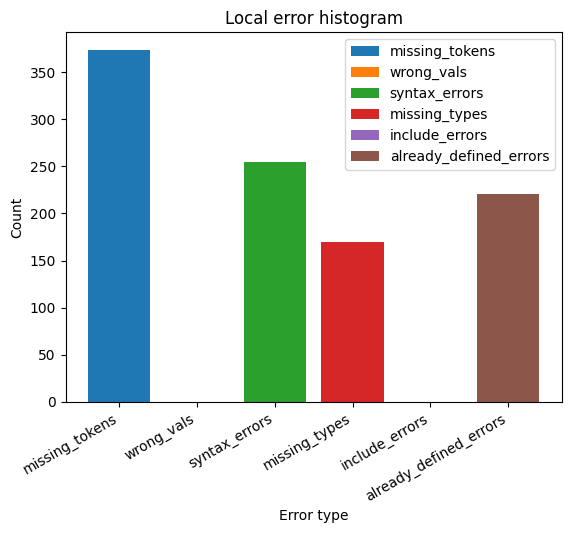

In [17]:
local_errors_count = sum_dicts(count_local_errors_in_collection(train_db), count_local_errors_in_collection(validation_db))
plot_bar(local_errors_count.keys(), local_errors_count.values(), local_errors_count.keys(), "Local error histogram", "Error type", "Count", 30)

In [18]:
def count_local_errors():
    expected_token_re = re.compile(".*expected a \"(\S+)\"")
    
    def count_db(db) -> dict:
        d= {}
        kernels = db.aggregate([
            {"$match" : {"validation.compiled" : False}},
            {"$project" : {"_id" : "$_id", "filename" : "$filename", "last_validation" : {"$slice" : ["$validation.iterations", -1]}}},
        ])
        
        is_local_error = lambda error, filename: error.get("line").find(filename) != -1
        
        for kernel in tqdm(kernels):
            unique_error_set = set()
            filename = kernel.get("filename")
            last_validation = kernel.get("last_validation")[0]
            error_analyses = last_validation.get("error_analyses")
            for type, errors in error_analyses.items():
                if d.get(type) == None:
                    d[type] = 0
                
                for error in errors:
                    if is_local_error(error, filename):
                        if type == "missing_tokens":
                            if error.get("identifier") not in unique_error_set:
                                d[type] += 1
                                unique_error_set.add(error.get("identifier"))
                        elif type == "syntax_errors" and (res := expected_token_re.match(error["line"])) != None:
                            if  res[1] not in unique_error_set:
                                d[type] += 1
                                unique_error_set.add(res[1])
                        else:
                            d[type] += 1
                            
                d[type] += sum([1 for error in errors if is_local_error(error, filename)])
        
        return d

    return sum_dicts(count_db(train_db), count_db(validation_db))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

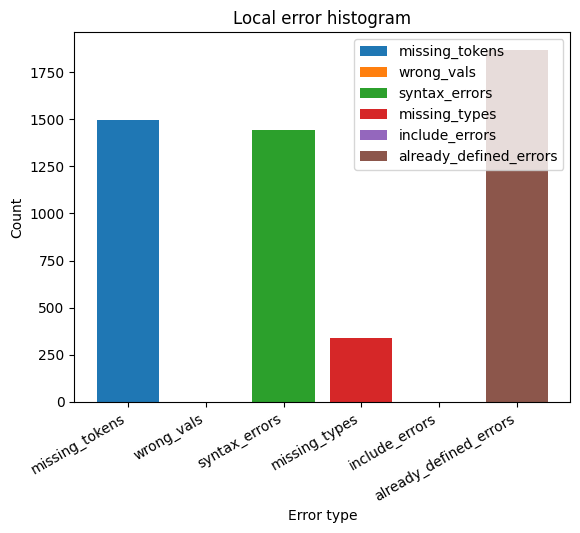

In [19]:
local_errors_count = count_local_errors()
plot_bar(local_errors_count.keys(), local_errors_count.values(), local_errors_count.keys(), "Local error histogram", "Error type", "Count", 30)

### Mark syntatically bad kernels

In [22]:
def mark_bad_kernels():
    
    def mark_db(db) -> None:
        kernels = db.aggregate([
            {"$match" : {"validation.compiled" : False}},
            {"$project" : {"_id" : "$_id", "filename" : "$filename", "last_validation" : {"$slice" : ["$validation.iterations", -1]}}},
        ])
        
        is_local_error = lambda error, filename: error.get("line").find(filename) != -1
        
        for kernel in tqdm(kernels):
            filename = kernel.get("filename")
            last_validation = kernel.get("last_validation")[0]
            error_analyses = last_validation.get("error_analyses")
            for errors in error_analyses.values():                
                for error in errors:
                    if is_local_error(error, filename):
                        db.update_one({"_id" : kernel.get("_id")}, {"$set" : {"metadata.correct_syntax" : False}})
                        break
    mark_db(train_db)
    mark_db(validation_db)

train_db.update_many({}, {"$unset" : {"metadata.correct_syntax" : ""}})
validation_db.update_many({}, {"$unset" : {"metadata.correct_syntax" : ""}})

mark_bad_kernels()
train_db.update_many({"metadata.correct_syntax" : {"$exists" : False}}, {"$set" : {"metadata.correct_syntax" : True}})
validation_db.update_many({"metadata.correct_syntax" : {"$exists" : False}}, {"$set" : {"metadata.correct_syntax" : True}})

faulty_kernels = train_db.count_documents({"metadata.correct_syntax" : False}) + \
    validation_db.count_documents({"metadata.correct_syntax" : False})

correct_kernels = train_db.count_documents({"metadata.correct_syntax" : True}) + \
    validation_db.count_documents({"metadata.correct_syntax" : True})

total = correct_kernels + faulty_kernels
print(f"Syntatically correct kernels: {correct_kernels} ({correct_kernels/total:.2%})")
print(f"Syntatically faulty kernels: {faulty_kernels} ({faulty_kernels/total:.2%})")
print(f"Total kernels: {correct_kernels +  faulty_kernels}")



0it [00:00, ?it/s]

0it [00:00, ?it/s]

Syntatically correct kernels: 485904 (0.9989515104417225)
Syntatically faulty kernels: 510 (0.0010484895582775168)
Total kernels: 486414


### Sort kernels by prefixes

In [35]:
def count_kernel_prefixes():
    
    def count_kernel_prefixes_in_db(db):
        prefixes = {
            "other" : 0
        }
        
        other_kernels = []
        device_re = re.compile("__device__")
        host_re = re.compile("__host__")
        global_re = re.compile("__global__")
        
        for kernel in tqdm(db.find({"metadata.correct_syntax" : True})):
            header = kernel.get("header")
            found_prefixes = []
            if device_re.search(header) != None:
                found_prefixes.append("__device__")
            if host_re.search(header) != None:
                found_prefixes.append("__host__")
            if global_re.search(header) != None:
                found_prefixes.append("__global__")
            
            if len(found_prefixes) == 0:
                prefixes["other"] += 1
                other_kernels.append(kernel)
            else:
                prefix = "".join(found_prefixes)
                if prefix not in prefixes:
                    prefixes[prefix] = 0
                prefixes[prefix] += 1

        return prefixes, other_kernels
    
    train_count, train_other_kernels = count_kernel_prefixes_in_db(train_db)
    valid_count, valid_other_kernels = count_kernel_prefixes_in_db(validation_db)
    
    return sum_dicts(train_count, valid_count), train_other_kernels + valid_other_kernels      
            
kernel_prefix_count, other_kernels = count_kernel_prefixes()
pprint(kernel_prefix_count)
        

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'__device__': 156027,
 '__device____global__': 180,
 '__device____host__': 182943,
 '__device____host____global__': 70,
 '__global__': 128918,
 '__host__': 17680,
 '__host____global__': 72,
 'other': 0}


### Clean "other" kernels

In [34]:
ids = [kernel.get("_id") for kernel in other_kernels]
train_db.delete_many({"_id" : {"$in" : ids}})
validation_db.delete_many({"_id" : {"$in" : ids}})

### Mark cuda header prefixes to mongo

In [36]:
def mark_kernel_prefixes() -> None:
    
    def mark_kernel_prefixes_in_db(db) -> None:
        
        device_re = re.compile("__device__")
        host_re = re.compile("__host__")
        global_re = re.compile("__global__")
        
        for kernel in tqdm(db.find()):
            header = kernel.get("header")
            found_prefixes = []
            if device_re.search(header) != None:
                found_prefixes.append("__device__")
            if host_re.search(header) != None:
                found_prefixes.append("__host__")
            if global_re.search(header) != None:
                found_prefixes.append("__global__")
            
            db.update_one({"_id" : kernel.get("_id")}, {"$set" : {"metadata.header_cuda_prefixes" : found_prefixes}})
    
    mark_kernel_prefixes_in_db(train_db)
    mark_kernel_prefixes_in_db(validation_db)
    
mark_kernel_prefixes()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [39]:
not_marked_count = train_db.count_documents({"metadata.header_cuda_prefixes" : {"$exists" : False}}) + \
    validation_db.count_documents({"metadata.header_cuda_prefixes" : {"$exists" : False}})
print(f"Not marked {not_marked_count}")

Total 485890
Not marked 0


In [8]:
train_valid = train_db.count_documents({"metadata.correct_syntax" : True, 
                                        "$or" : [
                                            {"metadata.header_cuda_prefixes.0" : {"$ne" : "__host__"}},
                                            {"metadata.header_cuda_prefixes.1" : {"$exists" : True}}
                                        ]})
valid_valid = validation_db.count_documents({"metadata.correct_syntax" : True, 
                                        "$or" : [
                                            {"metadata.header_cuda_prefixes.0" : {"$ne" : "__host__"}},
                                            {"metadata.header_cuda_prefixes.1" : {"$exists" : True}}
                                        ]})

total_valid = train_valid + valid_valid
print(f"Train valid {train_valid}")
print(f"Valid valid {valid_valid}")
print(f"Total {total_valid}")

Train valid 431007
Valid valid 37203
Total 468210


### Find kernels with shared and const memory

In [5]:
def find_and_mark_optimized_kernels() -> dict:
    def find_and_mark_optimized_kernels_db(db) -> list:
        prefix_group_count = {}
        local_mem_re = re.compile(".*__(shared|constant)__")
        
        for kernel in tqdm(db.find({})):
            body = kernel.get("body").replace("\n", " ")
            if uses_local_mem := (local_mem_re.match(body) != None):
                kernel_cuda_prefix = "".join(kernel.get("metadata").get("header_cuda_prefixes"))
                if kernel_cuda_prefix not in prefix_group_count:
                    prefix_group_count[kernel_cuda_prefix] = 0
                prefix_group_count[kernel_cuda_prefix] += 1
            
            train_db.update_one({"_id" : kernel.get("_id")}, {"$set" : {"metadata.uses_local_mem" : uses_local_mem}})
        
        return prefix_group_count
    
    return sum_dicts(find_and_mark_optimized_kernels_db(train_db), find_and_mark_optimized_kernels_db(validation_db))


prefixes_group_count = find_and_mark_optimized_kernels()
pprint(prefixes_group_count)
print(f"Total optimized kernels : {sum(prefixes_group_count.values())}") 

0it [00:00, ?it/s]

NameError: name 'kernel_prefix_count' is not defined

### Kernels with generated comment

In [3]:
total = train_db.count_documents({}) + validation_db.count_documents({})

generated_comment_count = train_db.count_documents({"has_generated_comment" : True}) + \
    validation_db.count_documents({"has_generated_comment" : True})
    
print(f"Total: {total}")
print(f"Original  comment: {total-generated_comment_count} ({(total-generated_comment_count)/total:.2%})")
print(f"Generated comment: {generated_comment_count} ({generated_comment_count/total:.2%})")

    

Total: 486400
Original  comment: 95116 (19.56%)
Generated comment: 391284 (80.44%)


### Snipet length analyses

In [24]:
from collections import OrderedDict
from transformers import AutoTokenizer
    
def calculate_modus(l : Iterable) -> int:
    vals, counts = np.unique(l, return_counts=True)
    mode_value = np.argwhere(counts == np.max(counts))
    count = np.max(counts)
    return vals[mode_value].flatten().tolist()[0], count

def get_snippets_lengths(tokenizer_name = "gpt2") -> list:
    def _get_snippert_length_db(db, tokenizer):
        comment_l = {
            "raw" : [],
            "tokenized" : []
        }
        header_l = {
            "raw" : [],
            "tokenized" : []
        }
        body_l = {
            "raw" : [],
            "tokenized" : []
        }
        total_l = {
            "raw" : [],
            "tokenized" : []
        }

        for kernel in tqdm(db.find({})):
            comment = kernel.get("comment")
            header = kernel.get("header")
            body = kernel.get("body")
            total = f"{comment}\n{header}\n{body}"
            
            comment_l["raw"].append(len(comment))
            comment_l["tokenized"].append(len(tokenizer.encode(comment)))
            
            header_l["raw"].append(len(header))
            header_l["tokenized"].append(len(tokenizer.encode(header)))
            
            body_l["raw"].append(len(body))
            body_l["tokenized"].append(len(tokenizer.encode(body)))
            
            total_l["raw"].append(len(total))
            total_l["tokenized"].append(len(tokenizer.encode(total)))
    
        return comment_l, header_l, body_l, total_l
    
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    tokenizer.model_max_length = 999999
    
    t_comment_l, t_header_l, t_body_l, t_total_l = _get_snippert_length_db(train_db, tokenizer)
    v_comment_l, v_header_l, v_body_l, v_total_l = _get_snippert_length_db(validation_db, tokenizer)
    # v_comment_l, v_header_l, v_body_l, v_total_l = t_comment_l, t_header_l, t_body_l, t_total_l
    
    r_d = OrderedDict()
    r_d["comment"] = {"raw" : {}, "tokenized" : {}}
    r_d["header"] = {"raw" : {}, "tokenized" : {}}
    r_d["body"] = {"raw" : {}, "tokenized" : {}}
    r_d["total"] = {"raw" : {}, "tokenized" : {}}
    
    for t, (t_d, v_d) in zip(r_d.keys(), [(t_comment_l, v_comment_l), (t_header_l, v_header_l), (t_body_l, v_body_l), (t_total_l, v_total_l)]):
        r_d[t]["raw"]["average"] = np.average(t_d["raw"] + v_d["raw"])
        r_d[t]["tokenized"]["average"] = np.average(t_d["tokenized"] + v_d["tokenized"])
        
        r_d[t]["raw"]["median"] = np.median(t_d["raw"] + v_d["raw"])
        r_d[t]["tokenized"]["median"] = np.median(t_d["tokenized"] + v_d["tokenized"])
        
        r_d[t]["raw"]["mode"] = calculate_modus(t_d["raw"] + v_d["raw"])
        r_d[t]["tokenized"]["mode"] = calculate_modus(t_d["tokenized"] + v_d["tokenized"])
        
        r_d[t]["raw"]["list"] = t_d["raw"] + v_d["raw"]
        r_d[t]["tokenized"]["list"] = t_d["tokenized"] + v_d["tokenized"]
        
    return r_d
            

In [25]:
d = get_snippets_lengths()

0it [00:00, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1735140 > 999999). Running this sequence through the model will result in indexing errors


0it [00:00, ?it/s]

Type: Comment
Subtype: raw
Min: 3
Max: 13754
Average: 118.115
Median: 75.0
Mode: (58, 10288)

Type: Comment
Subtype: tokenized
Min: 2
Max: 5970
Average: 42.124
Median: 27.0
Mode: (27, 18325)



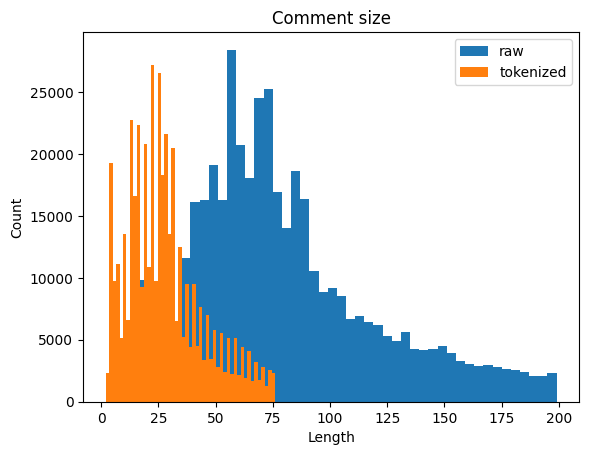

#----------------------------#

Type: Header
Subtype: raw
Min: 15
Max: 11514
Average: 120.050
Median: 71.0
Mode: (59, 16971)

Type: Header
Subtype: tokenized
Min: 5
Max: 6032
Average: 48.970
Median: 24.0
Mode: (19, 40747)



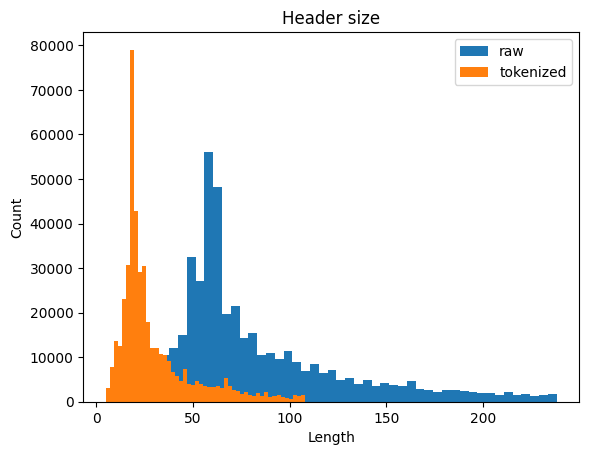

#----------------------------#

Type: Body
Subtype: raw
Min: 2
Max: 2538338
Average: 619.483
Median: 94.0
Mode: (2, 20930)

Type: Body
Subtype: tokenized
Min: 2
Max: 1735140
Average: 301.845
Median: 50.0
Mode: (2, 21785)



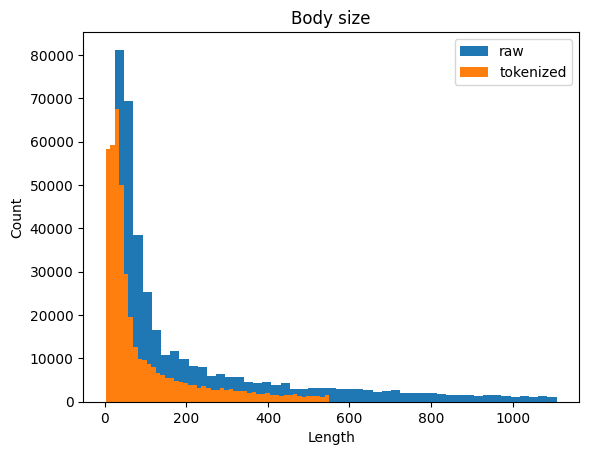

#----------------------------#

Type: Total
Subtype: raw
Min: 37
Max: 2538563
Average: 859.648
Median: 284.0
Mode: (172, 3143)

Type: Total
Subtype: tokenized
Min: 13
Max: 1735245
Average: 394.939
Median: 119.0
Mode: (73, 5596)



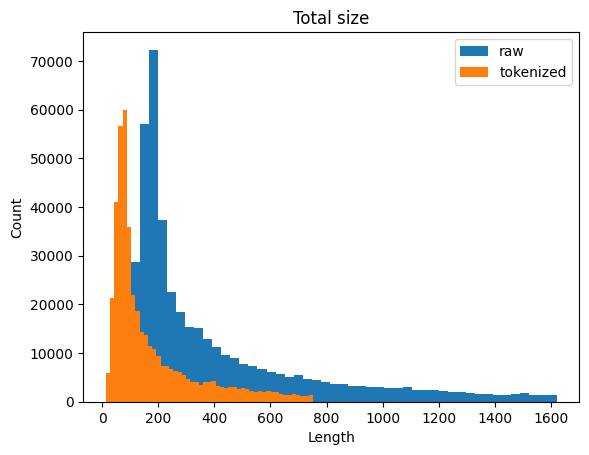

#----------------------------#



In [38]:
for t, vals in d.items(): # comment, header, body, total
    for vt, v_vals in vals.items(): # raw, tokenized
        # for vvt, vv_vals in v_vals.items(): # average, mean, modus, list
        
        t = str(list(t)[0].upper()) + t[1:]
        
        avg = v_vals["average"]
        median = v_vals["median"]
        modus = v_vals["mode"]
        l = v_vals["list"]
        min_l = min(l)
        max_l = max(l)
        
        print(f"Type: {t}")
        print(f"Subtype: {vt}")
        print(f"Min: {min_l}")
        print(f"Max: {max_l}")
        print(f"Average: {avg:.3f}")
        print(f"Median: {median}")
        print(f"Mode: {modus}")
        print()
        
        q = np.quantile(l, 0.9)

        r = np.linspace(min_l, q, 50)
        plt.title(f"{t} size")
        plt.xlabel("Length")
        plt.ylabel("Count")
        plt.hist(l, r, label=vt)
    
    plt.legend()    
    plt.show()
    print("#----------------------------#\n")
        
        